In [1]:
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [2]:
path = os.getcwd()

In [3]:
file_path = path + '/' + 'rfe_data.csv'
data = pd.read_csv(file_path)

data

,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,EYE_STATUS_AT_SCAN,HANDEDNESS_L,HANDEDNESS_R,...,7289,7300,7301,7310,7311,7322,7334,7346,7370,7372
0,50003,1,24.45,1,124.0,128.0,115.0,2,0,1,...,0.033260,-0.041632,-0.059341,-0.121557,-0.012383,0.025517,0.052547,-0.063991,0.010787,-0.050443
1,50004,1,19.09,1,113.0,108.0,117.0,2,0,1,...,0.050611,-0.042567,0.093074,0.109330,0.020102,0.032080,0.007427,0.057831,0.156841,-0.033594
2,50005,1,13.73,2,119.0,117.0,118.0,2,0,1,...,0.071979,0.067687,-0.110755,0.070463,-0.128744,-0.015560,0.016788,0.085606,0.164743,0.017362
3,50006,1,13.37,1,109.0,99.0,119.0,2,1,0,...,-0.248795,-0.134857,0.003467,0.028476,-0.064450,0.017273,-0.134312,-0.160807,-0.064048,0.006421
4,50007,1,17.78,1,110.0,106.0,112.0,2,0,1,...,0.118648,0.108341,0.062105,-0.048163,-0.056274,0.092460,-0.102870,0.108533,-0.061043,-0.050112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,51491,2,56.20,1,120.0,109.0,128.0,2,0,1,...,-0.155725,0.102645,-0.022730,-0.045283,-0.127412,0.023730,-0.015425,0.039921,-0.166064,-0.045016
583,51493,2,29.20,2,102.0,101.0,103.0,2,0,1,...,-0.010598,0.005643,0.061040,0.031472,0.019633,0.313212,0.131851,0.151365,0.065520,0.002497
584,51578,1,33.00,1,125.0,129.0,113.0,2,0,0,...,0.082790,0.132999,0.001792,0.049706,-0.132497,0.122863,0.162486,0.099827,-0.086288,-0.141982
585,51583,1,35.00,1,95.0,105.0,84.0,2,0,0,...,0.074411,0.062565,0.083064,-0.010998,-0.066113,0.280972,0.212417,0.112259,0.092358,-0.099759


In [4]:
features = data.drop(columns=['SUB_ID', 'DX_GROUP', 'FILE_ID', 'EYE_STATUS_AT_SCAN', 'AGE_AT_SCAN', 'SEX', 'FIQ', 'VIQ', 'PIQ',
       'HANDEDNESS_L', 'HANDEDNESS_R'])
labels = data['DX_GROUP']

In [5]:
features.head(5)

,21,53,87,91,92,96,127,144,177,197,...,7289,7300,7301,7310,7311,7322,7334,7346,7370,7372
0,-0.103432,0.104428,0.038506,0.024291,-0.092303,-0.059260,0.164237,0.106613,0.021813,-0.037500,...,0.033260,-0.041632,-0.059341,-0.121557,-0.012383,0.025517,0.052547,-0.063991,0.010787,-0.050443
1,-0.176959,-0.070679,0.039701,-0.007292,0.022309,-0.145117,0.105095,-0.189229,0.102463,-0.031367,...,0.050611,-0.042567,0.093074,0.109330,0.020102,0.032080,0.007427,0.057831,0.156841,-0.033594
2,-0.128177,-0.117809,0.108323,-0.064551,-0.052110,0.009176,-0.002572,0.063183,0.081086,-0.006995,...,0.071979,0.067687,-0.110755,0.070463,-0.128744,-0.015560,0.016788,0.085606,0.164743,0.017362
3,-0.234789,-0.071212,0.137560,-0.042172,-0.072873,0.005231,-0.008780,-0.077436,0.041041,-0.047330,...,-0.248795,-0.134857,0.003467,0.028476,-0.064450,0.017273,-0.134312,-0.160807,-0.064048,0.006421
4,-0.128724,-0.076194,0.052683,-0.005324,0.059897,-0.018977,0.076136,-0.307068,0.030221,-0.146371,...,0.118648,0.108341,0.062105,-0.048163,-0.056274,0.092460,-0.102870,0.108533,-0.061043,-0.050112


c:\Users\merye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 99.15%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


c:\Users\merye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 100.00%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\merye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 99.15%


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020EE0001F80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\merye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 100.00%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\merye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 100.00%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Total training time: 39.99 seconds
Mean accuracy over 5 folds: 99.66%
Standard deviation over 5 folds: 0.42%


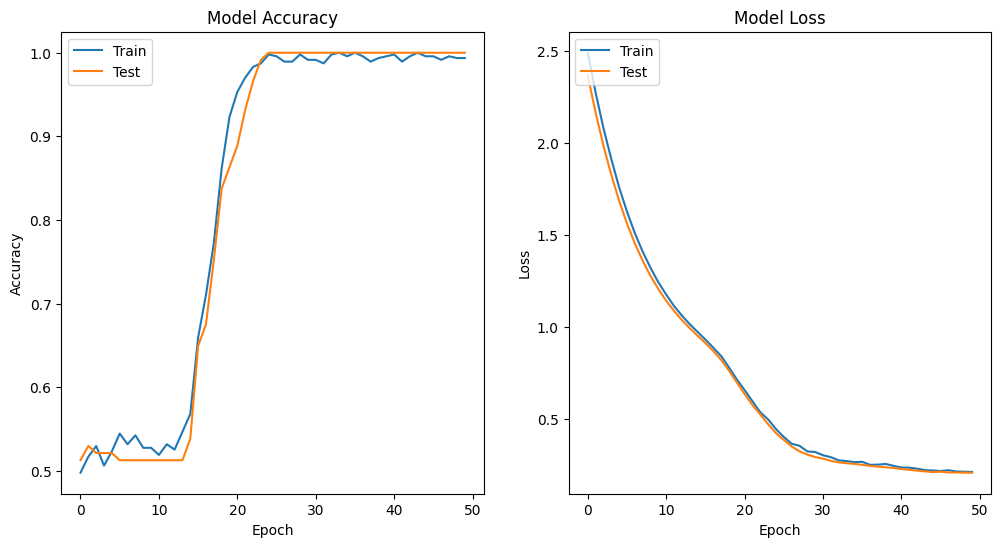

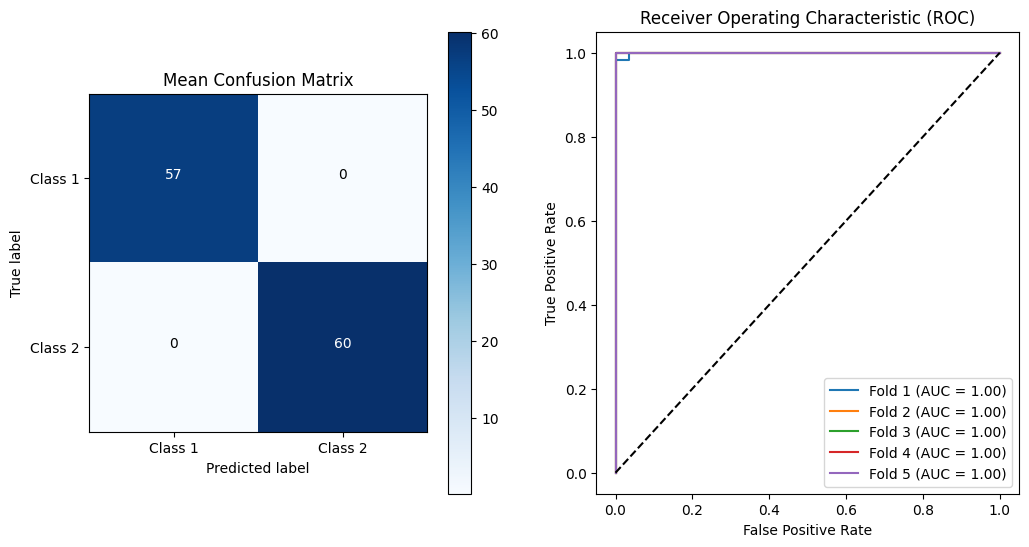

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, test_size=0.2, random_state=42)

# Hyperparameters
optimal_units = 50
optimal_l2 = 0.01
optimal_dropout_rate = 0.5
optimal_learning_rate = 0.0005
optimal_epochs = 50
batch_size = 32

best_model = None
best_accuracy = 0

def build_optimal_model(input_dim):
    model = Sequential()
    model.add(Dense(optimal_units, input_dim=input_dim, activation='relu', kernel_regularizer=l2(optimal_l2)))
    model.add(Dropout(optimal_dropout_rate))
    model.add(Dense(optimal_units, activation='relu', kernel_regularizer=l2(optimal_l2)))
    model.add(Dropout(optimal_dropout_rate))
    model.add(Dense(optimal_units, activation='relu', kernel_regularizer=l2(optimal_l2)))
    model.add(Dropout(optimal_dropout_rate))
    model.add(Dense(2, activation='sigmoid'))

    optimizer = Adam(learning_rate=optimal_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_conf_matrices = []
fold_roc_curves = []
fold_auc_scores = []

start_time = time.time()  # Start timing

for train_index, test_index in kfold.split(features, labels):
    X_train_fold, X_test_fold = features.values[train_index], features.values[test_index]
    y_train_fold, y_test_fold = labels.values[train_index], labels.values[test_index]

    y_train_fold = to_categorical(y_train_fold - 1, num_classes=2)
    y_test_fold = to_categorical(y_test_fold - 1, num_classes=2)

    model = build_optimal_model(X_train_fold.shape[1])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train_fold, y_train_fold, epochs=optimal_epochs, batch_size=batch_size, validation_data=(X_test_fold, y_test_fold), callbacks=[early_stopping], verbose=0)

    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Fold accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1]*100)

    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model
        best_model.save('best_model_FMRI_RFE.h5')

    # Predictions
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_fold, axis=1)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    fold_conf_matrices.append(conf_matrix)

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    fold_roc_curves.append((fpr, tpr))
    fold_auc_scores.append(roc_auc)

end_time = time.time()  # End time
print(f"Total training time: {end_time - start_time:.2f} seconds")

mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"Mean accuracy over 5 folds: {mean_accuracy:.2f}%")
print(f"Standard deviation over 5 folds: {std_accuracy:.2f}%")

# Training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Confusion Matrix
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
mean_conf_matrix = np.mean(fold_conf_matrices, axis=0)
plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Mean Confusion Matrix')
plt.colorbar()
classes = ['Class 1', 'Class 2']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = mean_conf_matrix.max() / 2.
for i in range(mean_conf_matrix.shape[0]):
    for j in range(mean_conf_matrix.shape[1]):
        plt.text(j, i, f'{mean_conf_matrix[i, j]:.0f}',
                 horizontalalignment='center',
                 color='white' if mean_conf_matrix[i, j] > thresh else 'black')

# ROC Curve
plt.subplot(1, 2, 2)
for i, (fpr, tpr) in enumerate(fold_roc_curves):
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {fold_auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
